# Simple PE (modified from GWOSC)

Author date

When running in Google Colab, uncomment and run the cell to install latex for matplotlib:

## Install

When running in Google Colab, uncomment and run the cell to install required packages:

In [ ]:
#! pip install numpy scipy h5py matplotlib ipython jupyterlab tqdm lalsuite gwpy

When running in Google Colab, uncomment and run the cell to download the required data:

In [ ]:
#! mkdir data
#! wget https://www.github.com/SylvainMarsat/gwda_tutorial/blob/main/data/H-H1_LOSC_4_V2-1126259446-32.hdf5 -P data/

When running in Google Colab, uncomment and run the cell to install latex for matplotlib:

In [ ]:
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

## Imports

In [1]:
import os, sys
import h5py, json
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from tqdm.notebook import tqdm as tqdm

import astropy.units as u

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio") # to silence a warning
import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wfm
from lalsimulation.gwsignal import gwsignal_get_waveform_generator

import lisabeta
import lisabeta.waveforms.bbh.pyIMRPhenomD as pyIMRPhenomD
import ptemcee

import eryn
import corner

The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
# import lisabeta
# import lisabeta.pyconstants as pyconstants
# import lisabeta.tools.pytools as pytools
# import lisabeta.tools.pyspline as pyspline
# import lisabeta.lisa.lisatools as lisatools
# import lisabeta.lisa.lisa as lisa
# import lisabeta.waveforms.bbh.pyIMRPhenomD as pyIMRPhenomD
# import lisabeta.inference.inference as inference
# import lisabeta.utils.plotutils as plotutils
# import lisabeta.utils.corner_covar as corner_covar

# import ptemcee

# plt.rcParams.update({'figure.dpi': 100})

In [3]:
losc_dir = '/Users/marsat/Projects/tutorials/gwda/LOSC_Event_tutorial/'

In [4]:
sys.path.append(losc_dir)

import readligo as rl

In [5]:
%matplotlib inline

## Definitions

In [6]:
# Definitions for the windowing function -- function for vectorial argument
# In order to avoid overflows in the exponentials, we set the boundaries (di, df) so that anything below 10^-20 is considered zero
def window_planck(x, xi, xf, deltaxi, deltaxf):
    di = deltaxi/(20*np.log(10))
    df = deltaxf/(20*np.log(10))
    w = np.zeros(len(x), dtype=float)
    #
    mask = (x <= xi + di) | (x >= xf - df)
    w[mask] = 0.
    #
    mask = (xi + di < x) & (x < xi + deltaxi - di)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(deltaxi/(xm - xi) + deltaxi/(xm - (xi + deltaxi))))
    #
    mask = (xi + deltaxi - di <= x) & (x <= xf - deltaxf + df)
    w[mask] = 1.
    #
    mask = (xf - deltaxf + df < x) & (x < xf - df)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(-(deltaxf/(xm - (xf - deltaxf))) - deltaxf/(xm - xf)))
    #
    return w

In [7]:
def fft_positivef(times, data):
    n = len(times)
    deltat = times[1] - times[0]
    deltaf = 1./(n*deltat)
    # Fast Fourier Transform
    freqs = deltaf*np.arange(n)
    # BEWARE: due to the different convention for the sign of Fourier frequencies, we have to reverse the FFT output
    # Beware also that the FFT treats effectively the initial time as 0
    # BEWARE: in the reversion of the numpy-convention FFT output, we have to set aside the 0-frequency term
    data_fd = deltat * np.fft.fft(data)
    # Discarding information on negative frequencies - if real timeseries in input, no information loss as the deleted values are the conjugate
    data_fd = data_fd[:n//2+1]
    freqs = freqs[:n//2+1]
    # Coming back to the initial times
    tshift = times[0]
    fac_timeshift = np.exp(1j*2*np.pi*freqs*tshift)
    data_fd = data_fd * fac_timeshift
    return freqs, data_fd

In [8]:
# Read the event properties from a local json file
fnjson = losc_dir + 'BBH_events_v3.json'
events = json.load(open(fnjson, 'r'))

eventname = 'GW150914'
# eventname = 'GW151226'
events[eventname]

{'name': 'GW150914',
 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_template': 'GW150914_4_template.hdf5',
 'fs': 4096,
 'tevent': 1126259462.44,
 'utcevent': '2015-09-14T09:50:45.44',
 'm1': 41.743,
 'm2': 29.237,
 'a1': 0.355,
 'a2': -0.769,
 'approx': 'lalsim.SEOBNRv2',
 'fband': [43.0, 300.0],
 'f_min': 10.0}

In [9]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

In [10]:
def psd_smooth(freqs):
    return (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2

## Strain data

In [11]:
# read in data from H1 and L1, if available:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(losc_dir + fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(losc_dir + fn_L1, 'L1')

# Remove a constant shift of -1e-18 in the L1 strain, not sure why it's here
strain_L1 += 1e-18

In [12]:
# both H1 and L1 will have the same time vector, so:
# set t=0 at the middle of the interval
time = time_H1 - time_H1[len(time_H1)//2]
tevent = tevent - time_H1[len(time_H1)//2]
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

dt, 1./dt, time[-1] - time[0], len(time)

(np.float64(0.000244140625),
 np.float64(4096.0),
 np.float64(31.999755859375),
 131072)

NameError: name 'plotutils' is not defined

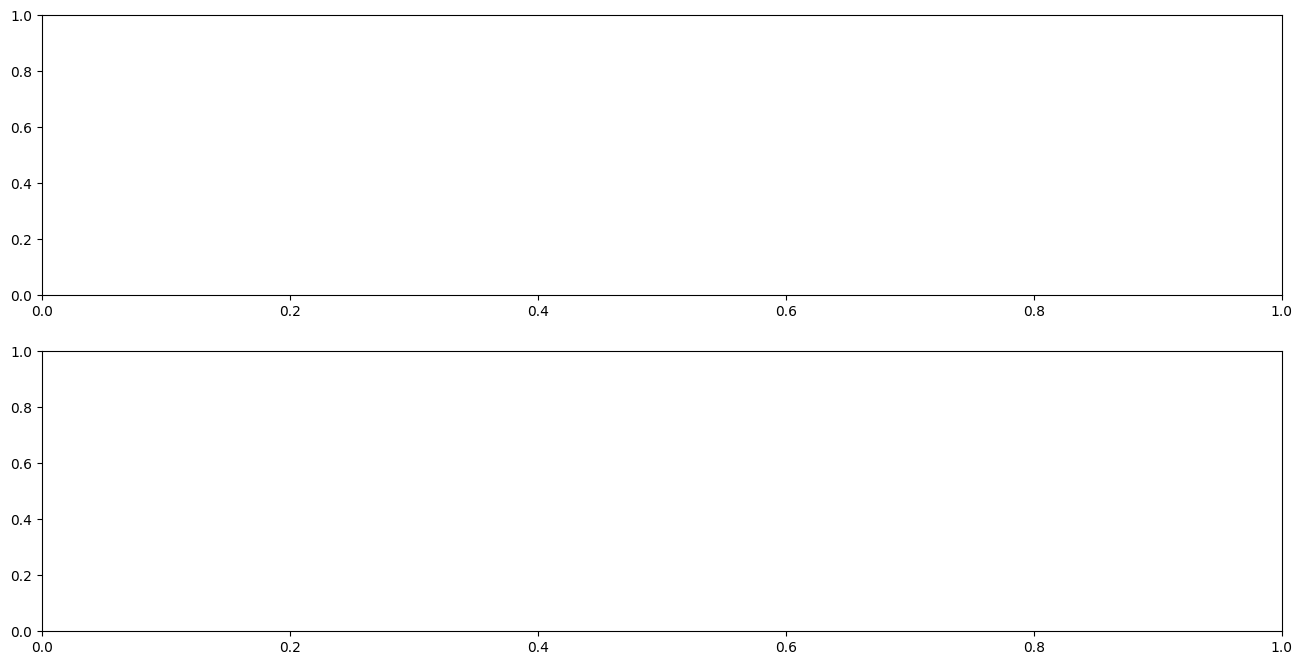

In [12]:
deltat = 5
mask = (tevent - deltat <= time) & (time <= tevent + deltat)
rangey = [-1e-18, 1e-18]

fig, axs = plt.subplots(2,1, figsize=[16,8])
plotutils.lplot(axs[0], [time[mask], strain_H1[mask]], rangey=rangey)
plotutils.lplot(axs[1], [time[mask], strain_L1[mask]], colors=[plotutils.plotpalette[1]], rangey=rangey)
axs[0].set_ylabel(r'Strain H1')
axs[1].set_ylabel(r'Strain L1')
for i in range(2):
    axs[i].set_xlabel(r'$t \; (s)$')
    axs[i].axvline(tevent, c='k', lw=0.5)

fig.tight_layout()

# fig.savefig('./plots/strain_raw_GW150914.pdf')

## Evaluate PSD

In [13]:
NFFT = 4*fs

Pxx_H1, freqs = mlab.psd(strain_H1, Fs=fs, NFFT=NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs=fs, NFFT=NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

In [14]:
Pxx_H1.shape

(8193,)

In [15]:
freqs

array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 2.04750e+03,
       2.04775e+03, 2.04800e+03], shape=(8193,))

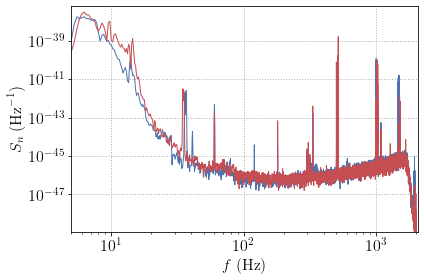

<Figure size 576x288 with 0 Axes>

In [15]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [freqs, Pxx_H1], [freqs, Pxx_L1], rangex=[5., 2048.])
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')

fig.tight_layout()

# fig.savefig('./plots/psd_GW150914.pdf')

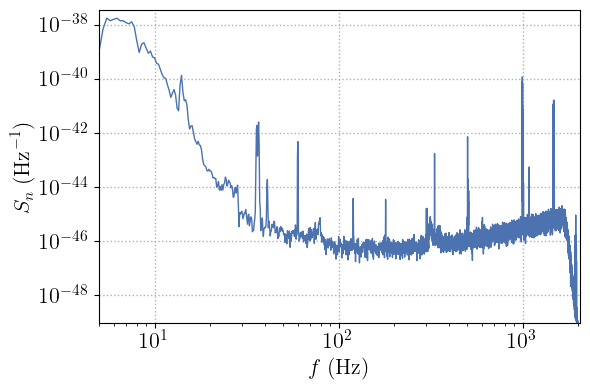

<Figure size 800x400 with 0 Axes>

In [303]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [freqs, Pxx_H1], rangex=[5., 2048.])
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')

fig.tight_layout()

# fig.savefig('./plots/psd_GW150914.pdf')

## Signal model: A exp(i alpha) * h22(f)

In [14]:
gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator('IMRPhenomXAS')

def signal_h(freq, M, q, A, Deltat, alpha, f_ref=100., phi_ref=0.):
    m1 = M * q / (1+q)
    m2 = M * 1. / (1+q)
    dist = 1e3
    chi1 = 0.
    chi2 = 0.

    # Assumes that the frequencies are equally spaced with a fixed deltaf
    f_min = freq[0]
    f_max = freq[-1]
    deltaf = freq[1] - freq[0]
    
    python_dict = {
              'mass1' : m1*u.solMass,
              'mass2' : m2*u.solMass,
              'spin1x' : 0.*u.dimensionless_unscaled,
              'spin1y' : 0.*u.dimensionless_unscaled,
              'spin1z' : chi1*u.dimensionless_unscaled,
              'spin2x' : 0.*u.dimensionless_unscaled,
              'spin2y' : 0.*u.dimensionless_unscaled,
              'spin2z' : chi2*u.dimensionless_unscaled,
              'deltaF' : deltaf*u.Hz,
              'f22_start' : f_min*u.Hz,
              'f_max' : f_max*u.Hz,
              'f22_ref': f_ref*u.Hz,
              'phi_ref' : phi_ref*u.rad,
              'distance' : dist*u.Mpc,
              'inclination' : 0.*u.rad,
              'eccentricity' : 0.*u.dimensionless_unscaled,
              'longAscNodes' : 0.*u.rad,
              'meanPerAno' : 0.*u.rad,
                'condition': 0}
    # hlm = wfm.GenerateFDModes(python_dict, gen)
    hp, hc = wfm.GenerateFDWaveform(python_dict, gen)
    
    # hfreq = np.asarray(hlm['frequency_array'])    
    hfreq = np.asarray(hp.frequencies)
    mask = (f_min <= hfreq) & (hfreq <= f_max)
    
    # h2m2vals = np.asarray(hlm[(2,-2)])
    h2m2vals = hp - 1j * hc
    h = A * np.exp(1j*alpha) * np.exp(1j* 2*np.pi * freq*Deltat) * h2m2vals[mask]

    return hfreq[mask], h

/Users/marsat/miniconda3/envs/gwda_tutorial/lib/python3.12/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [15]:
def signal_h(freq, M, q, A, Deltat, alpha):
    m1 = M * q / (1+q)
    m2 = M * 1. / (1+q)
    dist = 1e3
    chi1 = 0.
    chi2 = 0.
    wfClass = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq, m1, m2, chi1, chi2, dist)
    hlm = wfClass.get_waveform()
    h = hlm[(2,2)]
    h['amp'] *= A
    h['phase'] *= -1 # Change phase convention
    h['phase'] -= alpha
    h['phase'] += -2*np.pi*h['freq']*Deltat
    h['tf'] += Deltat
    return h

In [123]:
signal_lnLmax = {}
signal_lnLmax['amp'] = np.load('../../gwda/gwda/test/test_h_lnLmax_amp.npy')
signal_lnLmax['phase'] = np.load('../../gwda/gwda/test/test_h_lnLmax_phase.npy')

In [134]:
M, q, A, Deltat, alpha = np.array([ 7.32045084e+01,  1.32900290e+00,  3.94760472e-01,  4.27858963e-01,
        -5.70273657e-02])
signal_lnLmax_new = signal_h(freq, M, q, A, Deltat, alpha)

In [130]:
m1 = M * q / (1+q)
m2 = M * 1. / (1+q)
dist = 1e3
chi1 = 0.
chi2 = 0.
wfClass = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq, m1, m2, chi1, chi2, dist)
hlm = wfClass.get_waveform()
h = hlm[(2,2)]
h['phase']

array([148.32365525, 147.49805261, 146.67953592, ...,
         0.        ,   0.        ,   0.        ], shape=(32447,))

In [132]:
h['phase'].shape

(32447,)

In [131]:
freq

array([  10.03125,   10.0625 ,   10.09375, ..., 1023.90625,
       1023.9375 , 1023.96875], shape=(32447,))

In [125]:
signal_lnLmax_new['amp'] / signal_lnLmax['amp']

array([1., 1., 1., ..., 0., 0., 0.], shape=(32447,))

In [135]:
signal_lnLmax_new['phase'] + signal_lnLmax['phase']

array([0.        , 0.        , 0.        , ..., 1.55104607,
       1.5512192 , 1.55139234], shape=(32447,))

## Setting up data, prior and likelihood

In [16]:
# Data selected to be +-2s around the event
# _d for 'data' that we are going to actually use

# n = 2**np.round(np.log2(4. / dt))
n = len(time)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
time_d = time[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(time_d), [time_d[0], time_d[-1]]

(131072,
 np.float64(32.0),
 131072,
 [np.float64(-16.0), np.float64(15.999755859375)])

In [17]:
# Tapering data at both ends
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = window_planck(time_d, time_d[0], time_d[-1], 2., 2.)
strain_H1_tap = w * strain_H1_d
strain_L1_tap = w * strain_L1_d

In [18]:
# Data FD
freq_H1, strain_H1_fd = fft_positivef(time_d, strain_H1_tap)
freq_L1, strain_L1_fd = fft_positivef(time_d, strain_L1_tap)

df = freq_H1[1] - freq_H1[0]
df

np.float64(0.03125)

In [17]:
strain_H1_fd

array([-3.36929228e-21+0.00000000e+00j,
       -7.53438894e-21-8.97287279e-21j,
        8.29698209e-20+5.18711843e-20j, ...,
        5.04134829e-26-2.49618162e-26j,
       -1.75787996e-25+1.80210224e-25j,
       -5.34824181e-25-4.29241612e-36j], shape=(65537,))

In [26]:
# Frequency range for inner products
mask = (10. < freq_H1) & (freq_H1 < 1024.)
freq = freq_H1[mask]
freq.shape

(32447,)

In [27]:
freq

array([  10.03125,   10.0625 ,   10.09375, ..., 1023.90625,
       1023.9375 , 1023.96875], shape=(32447,))

In [26]:
h = signal_h(freq, 60., 1.5, 1., 0., np.pi/3)

In [56]:
np.allclose(f, freq)

True

In [57]:
%timeit signal_h(freq, 60., 1.5, 1., 0., np.pi/3)

49 ms ± 751 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%timeit signal_h(freq, 60., 1.5, 1., 0., np.pi/3)

18.6 ms ± 427 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit signal_h(freq, 60., 1.5, 1., 0., np.pi/3)

1.93 ms ± 86.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
psd_vals = psd_H1(freq)
invpsd_vals = 1./psd_vals

data = strain_H1_fd[mask]

In [30]:
def prior_check(x, prior_bounds):
    if prior_bounds is None:
        return True
    else:
        # NOTE: the following (faster) raises 'list indices must be integers or slices, not tuple'
        # but seems to depend on the version of python/numpy ?
        # return np.all((prior_bounds[:,0] <= x) * (x <= prior_bounds[:,1]))
        return np.all([(prior_bounds[i][0]<=x[i] and x[i]<=prior_bounds[i][1]) for i in range(len(x))])

def lnprior(x, prior_bounds=None):
    if not prior_check(x, prior_bounds):
        return -1e99
    else:
        return 0.

In [31]:
def lnlike(x, prior_bounds=None):
    if not prior_check(x, prior_bounds):
        return -1e99
    else:
        M, q, A, Deltat, alpha = x
        h = signal_h(freq, M, q, A, Deltat, alpha)
        h_vals = h['amp'] * np.exp(1j * h['phase'])
        resid = h_vals - data
        integrand = np.real(resid * np.conj(resid)) * invpsd_vals
        return -1./2 * 4*df* np.sum((integrand[1:] + integrand[:-1]) / 2)

## Setting up sampler - Eryn

In [29]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds

In [137]:
# Params: M, q, A, Deltat, alpha
prior_range = np.array([
    [50., 80.],
    [1., 2.],
    [0., 2.],
    [-1., 1.],
    [-np.pi, np.pi]])

In [138]:
# set prior limits
ndim = 5
priors_in = {i: uniform_dist(prior_range[i][0], prior_range[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)

In [139]:
ndim = 5
nwalkers = 64
ntemps = 5
Tmax = 100
nsteps = 1000
burn = int(nsteps/2)

# fill kwargs dictionary
tempering_kwargs=dict(ntemps=ntemps, Tmax=Tmax)

# Starting positions
# randomize throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))

# initialize sampler
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    lnlike,
    priors,
    args=[],
    kwargs={'prior_bounds': prior_range},
    tempering_kwargs=tempering_kwargs
)

In [140]:
out = ensemble.run_mcmc(coords, nsteps, burn=0, progress=True, thin_by=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:56<00:00,  1.87it/s]


In [141]:
samples = ensemble.get_chain()['model_0']
log_likelihoods = ensemble.get_log_like()
samples.shape, log_likelihoods.shape

((1000, 5, 64, 1, 5), (1000, 5, 64))

In [142]:
temp = 0
samples_T0 = samples[burn:][:, temp].reshape(-1, ndim)

In [143]:
samples_T0.shape

(32000, 5)

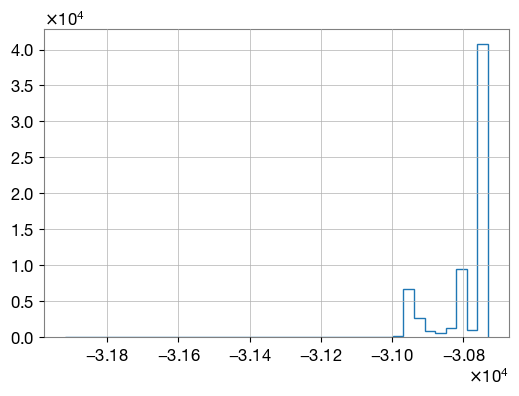

In [146]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(log_likelihoods[:,temp,:].flatten(), histtype='step', bins=40);

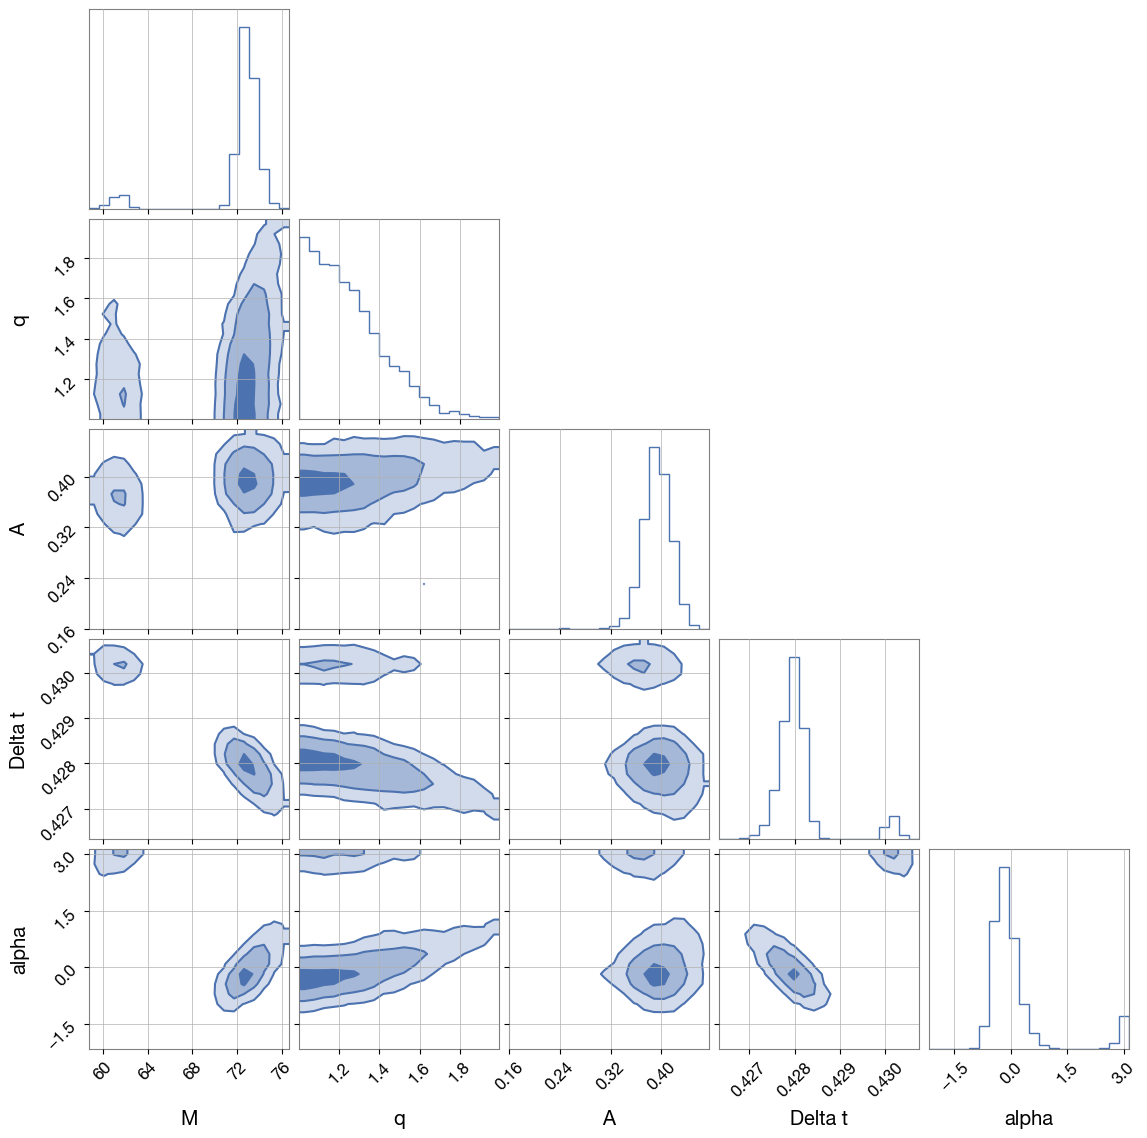

In [147]:
labels = [r'M', r'q', r'A', r'Delta t', r'alpha']
levels = 1.0 - np.exp(-0.5 * np.linspace(1.0, 3.0, num=3) ** 2)

corner.corner(samples_T0, plot_density=False, plot_datapoints=False, levels=levels, smooth=0.5, color='#4C72B0', fill_contours=True, labels=labels);

In [148]:
# array([ 7.32045084e+01,  1.32900290e+00,  3.94760472e-01,  4.27858963e-01,
#         -5.70273657e-02]),
#  -30730.802799080564,

lnlike(np.array([ 7.32045084e+01,  1.32900290e+00,  3.94760472e-01,  4.27858963e-01,
        -5.70273657e-02]))

np.float64(-30731.539182743567)

In [48]:
%timeit lnlike(xini[0,0,:])

2.32 ms ± 65.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Run PE - ptemcee

In [22]:
# Params: M, q, A, Deltat, alpha
prior_range = np.array([
    [50., 80.],
    [1., 2.],
    [0., 2.],
    [-1., 1.],
    [-np.pi, np.pi]])

In [32]:
ndim = 5
nwalkers = 64
ntemps = 5
Tmax = 100
niter = 1000
burn_in = int(niter/2)

datadir = './samples/'
name = 'gw150914_example'

# Initialization: draw from prior
xini = np.zeros((ntemps,nwalkers,ndim), dtype=float)
# Uniform f0, fdot0, amp, phi0, lambd, psi
for i in range(5):
    xini[:,:,i] = np.random.uniform(low=prior_range[i,0], high=prior_range[i,1], size=(ntemps,nwalkers))

# Temperatures
betas = ptemcee.sampler.make_ladder(ndim, ntemps=ntemps, Tmax=Tmax)

# Sampler
sampler = ptemcee.sampler.Sampler(nwalkers, ndim, lnlike, lnprior, logl_kwargs=[], logp_kwargs={'prior_bounds': prior_range}, betas=betas, adaptive=True, list_param_wrap=[None, None, None, None, [-np.pi, np.pi]])
chain = sampler.chain(xini)

# Initial likelihood values
lnLvals_ini = np.zeros((ntemps,nwalkers), dtype=float)
for i in range(ntemps):
    for j in range(nwalkers):
        lnLvals_ini[i,j] = lnlike(xini[i,j,:])

In [33]:
%time _ = chain.run(niter)

CPU times: user 13min 45s, sys: 2.62 s, total: 13min 48s
Wall time: 13min 48s


In [34]:
chain_unfold = np.transpose(chain.x[:,0,:,:], axes=(1,0,2))
# Same format without ndim for like and post values
lnlikevals = np.transpose(chain.logl[:,0,:], axes=(1,0))
lnpostvals = np.transpose(chain.logP[:,0,:], axes=(1,0))

thin_len = 1
n_fixed = 0
n_out = nwalkers * ((niter-burn_in-1) // thin_len + 1)
chain_processed = np.zeros((n_out, ndim + n_fixed), dtype=float)
for i in range(ndim):
#     i_out = list_params.index(infer_params[i])
    chain_processed[:,i] = np.ravel(chain_unfold[:,burn_in::thin_len,i],
                                        order='F')
lnlike_processed = np.ravel(lnlikevals[:,burn_in::thin_len], order='F')

# Output to file
np.save(datadir + 'chain_unfold_' + name + '.npy', chain_unfold)
np.save(datadir + 'lnlikevals_' + name + '.npy', lnlikevals)
np.save(datadir + 'chain_processed_' + name + '.npy', chain_processed)
np.save(datadir + 'lnlike_processed_' + name + '.npy', lnlike_processed)

## Results

In [35]:
datadir = './samples/'
name = 'gw150914_example'

chain_unfold = np.load(datadir + 'chain_unfold_' + name + '.npy')
lnlikevals = np.load(datadir + 'lnlikevals_' + name + '.npy')
chain_processed = np.load(datadir + 'chain_processed_' + name + '.npy')
lnlike_processed = np.load(datadir + 'lnlike_processed_' + name + '.npy')

In [36]:
chain_unfold.shape

(64, 1000, 5)

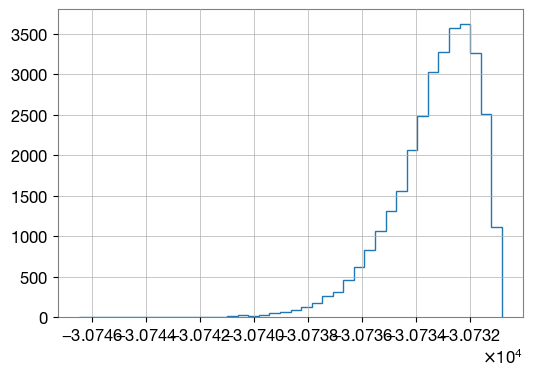

In [38]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(lnlike_processed, histtype='step', bins=40);

Text(0.5, 1.0, '')

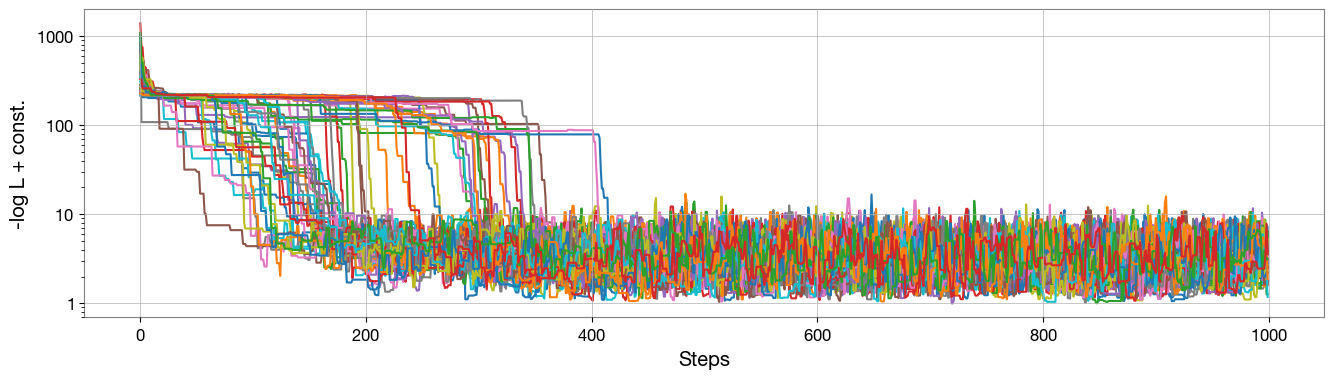

In [41]:
lnL_max = np.max(lnlike_processed)

fig, ax = plt.subplots(1,1, figsize=[16,4])
for i in range(lnlikevals.shape[0]):
    ax.plot(np.arange(lnlikevals.shape[1]), -(lnlikevals[i] - lnL_max - 1))

ax.set_yscale('log')
ax.set_xlabel(r'Steps')
ax.set_ylabel(r'-log L + const.')
ax.set_title(r'')

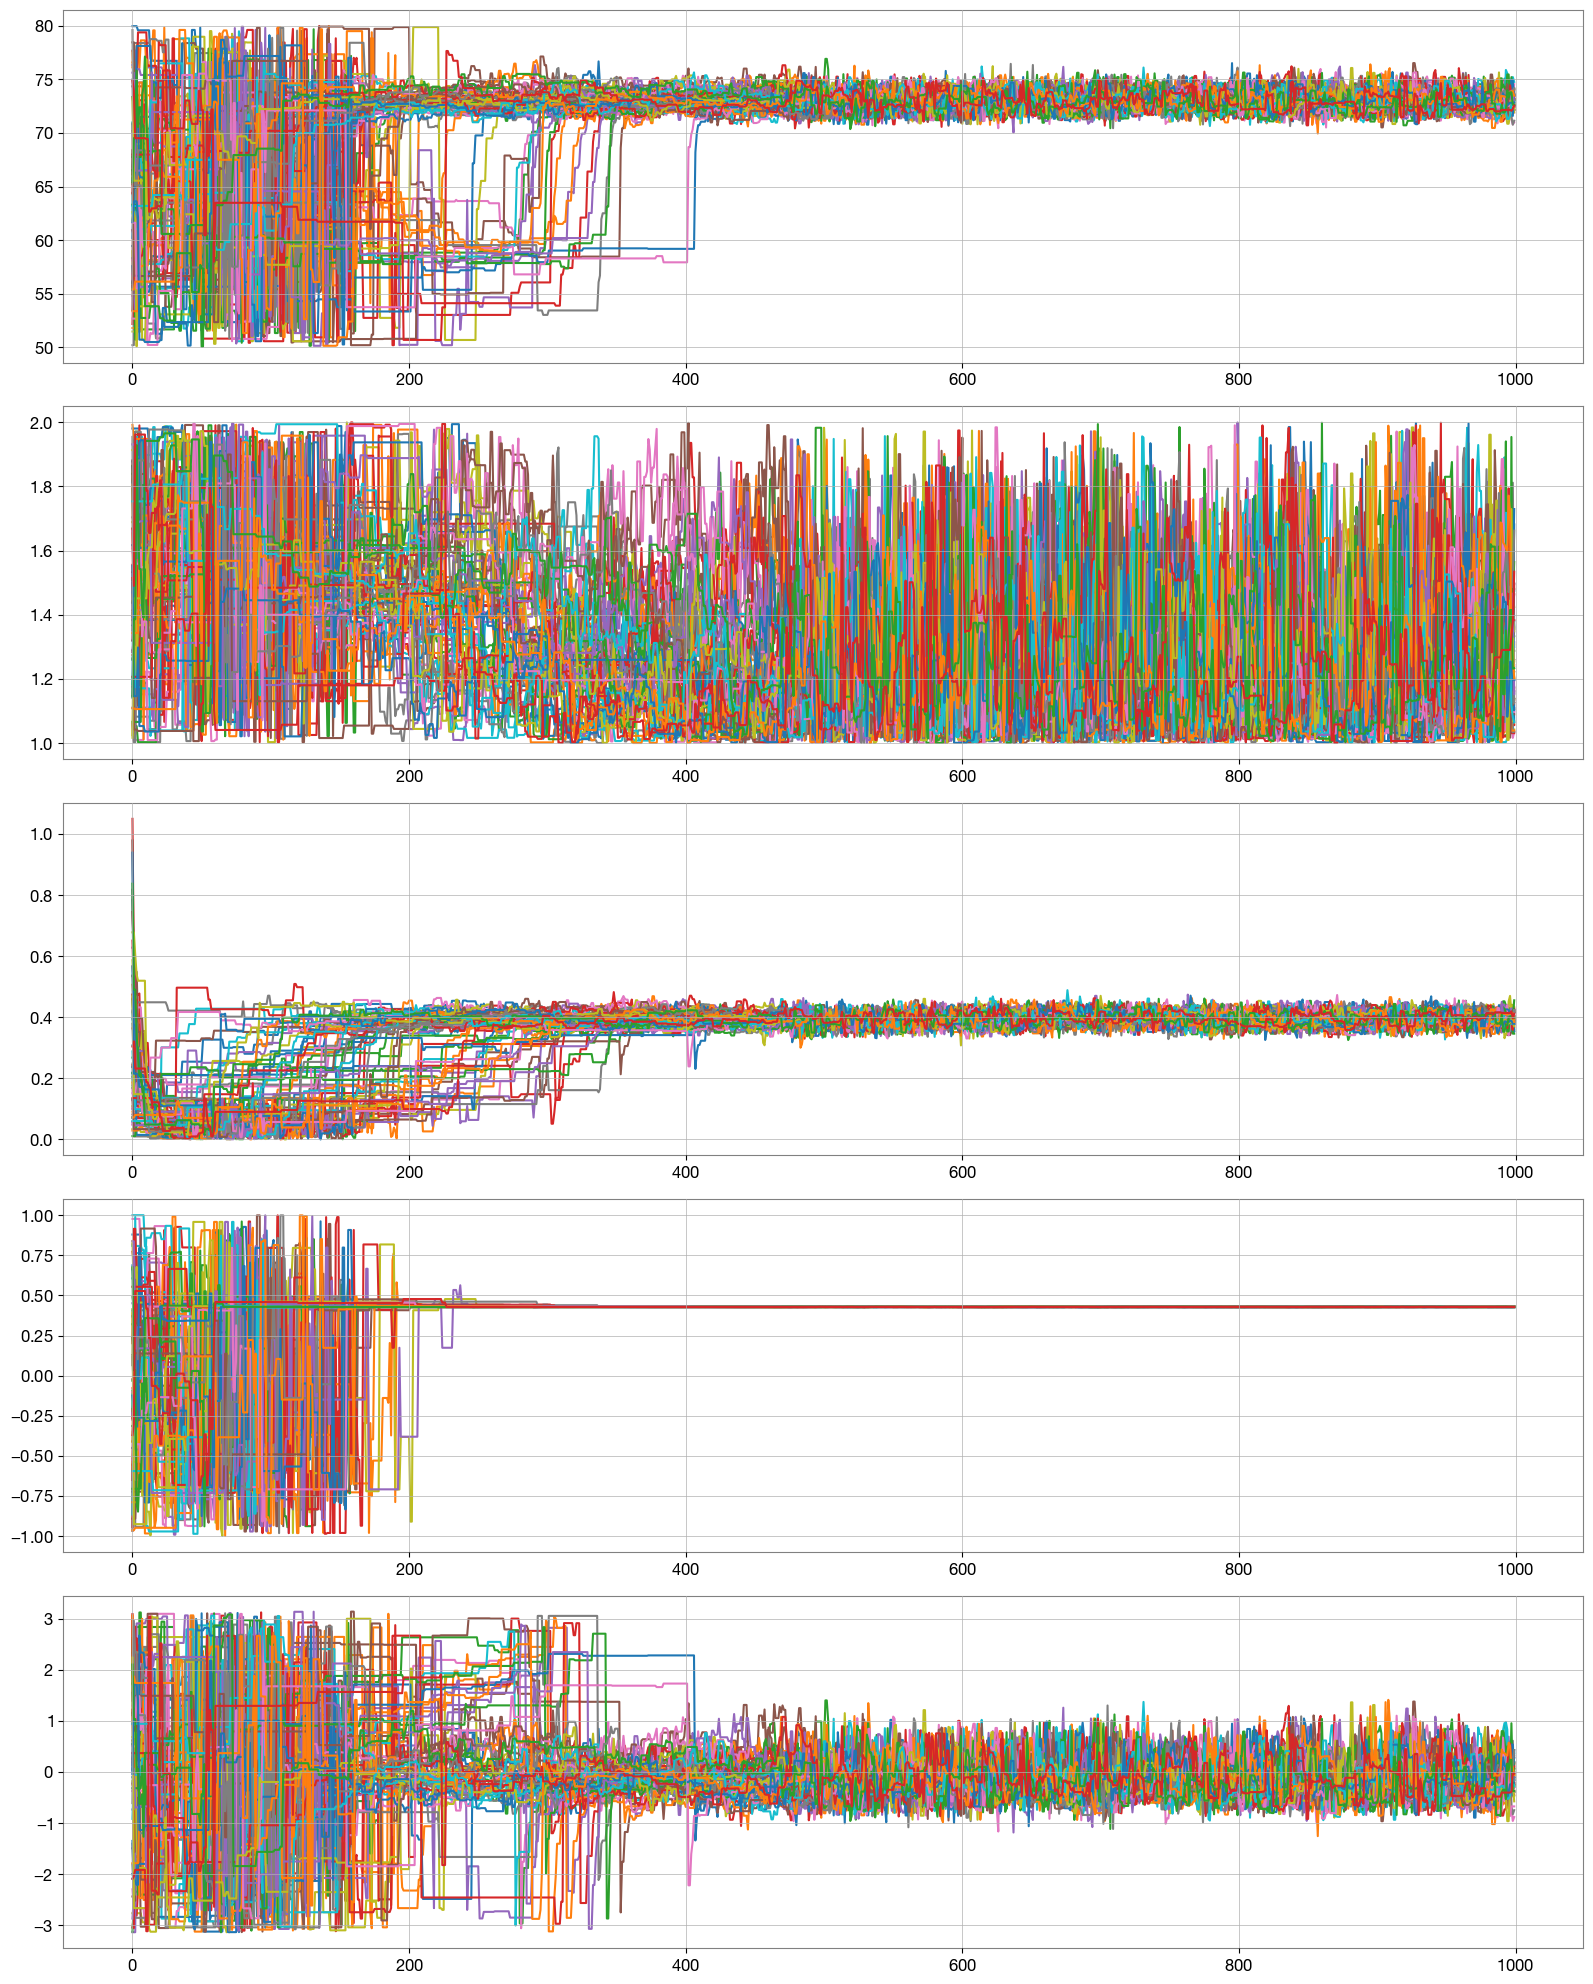

In [43]:
i = 0
pstr = 'M'

fig, axs = plt.subplots(5,1, figsize=[16,20])
for k in range(5):
    for i in range(lnlikevals.shape[0]):
        axs[k].plot(np.arange(lnlikevals.shape[1]), chain_unfold[i,:,k])

    ax.set_xlabel(r'Steps')
    # ax.set_ylabel(r'$-\ln \mathcal{L} + \mathrm{const.}$')
#     ax.set_title(r'')

fig.tight_layout()

In [44]:
lnlike_processed.shape, chain_processed.shape

((32000,), (32000, 5))

In [45]:
lnL_max = np.max(lnlike_processed)

imax = np.argmax(np.max(lnlike_processed))
xmax = chain_processed[imax]
xmax, lnL_max, len(freq)

(array([72.0409236 ,  1.25386116,  0.38852848,  0.42810148,
        -0.40978564]),
 np.float64(-30730.8138006195),
 32447)

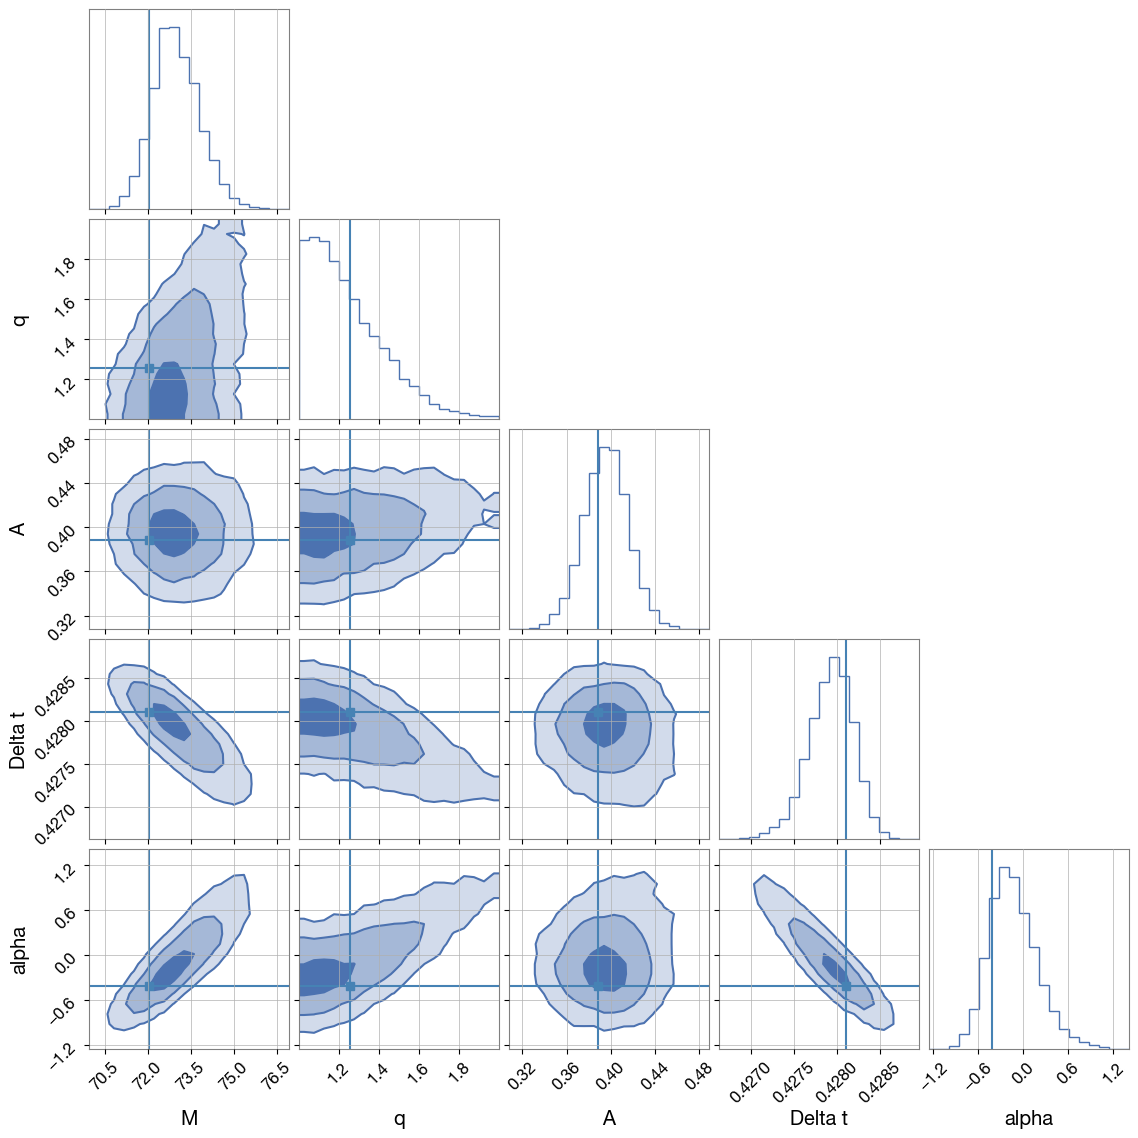

In [46]:
labels = [r'M', r'q', r'A', r'Delta t', r'alpha']
levels = 1.0 - np.exp(-0.5 * np.linspace(1.0, 3.0, num=3) ** 2)

corner.corner(chain_processed, truths=xmax, plot_density=False, plot_datapoints=False, levels=levels, smooth=0.5, color='#4C72B0', fill_contours=True, labels=labels);

## Waveform for max likelihood and residuals

In [91]:
# Data band-passed first, before whitening

freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_bp_vals = w_fft * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_bp_vals = w_fft * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_bp = np.array([freq_fft, np.real(strain_H1_fd_bp_vals), np.imag(strain_H1_fd_bp_vals)]).T
strain_L1_fd_bp = np.array([freq_fft, np.real(strain_L1_fd_bp_vals), np.imag(strain_L1_fd_bp_vals)]).T

strain_H1_td_bp = pytools.ifft_real(strain_H1_fd_bp)
strain_L1_td_bp = pytools.ifft_real(strain_L1_fd_bp)

In [92]:
# Data whitened after band-passing
freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_wbp_vals = 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])
strain_L1_fd_wbp_vals = 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd_bp[:,1] + 1j*strain_L1_fd_bp[:,2])
# strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_wbp = np.array([freq_fft, np.real(strain_H1_fd_wbp_vals), np.imag(strain_H1_fd_wbp_vals)]).T
strain_L1_fd_wbp = np.array([freq_fft, np.real(strain_L1_fd_wbp_vals), np.imag(strain_L1_fd_wbp_vals)]).T

strain_H1_td_wbp = pytools.ifft_real(strain_H1_fd_wbp)
strain_L1_td_wbp = pytools.ifft_real(strain_L1_fd_wbp)

In [93]:
M0, q0, A0, Deltat0, alpha0 = xmax
xmax

array([73.39540979,  1.07196342,  0.38900124,  0.42785137, -0.08974029])

In [94]:
h0 = signal_h(freq, M0, q0, A0, Deltat0, alpha0)

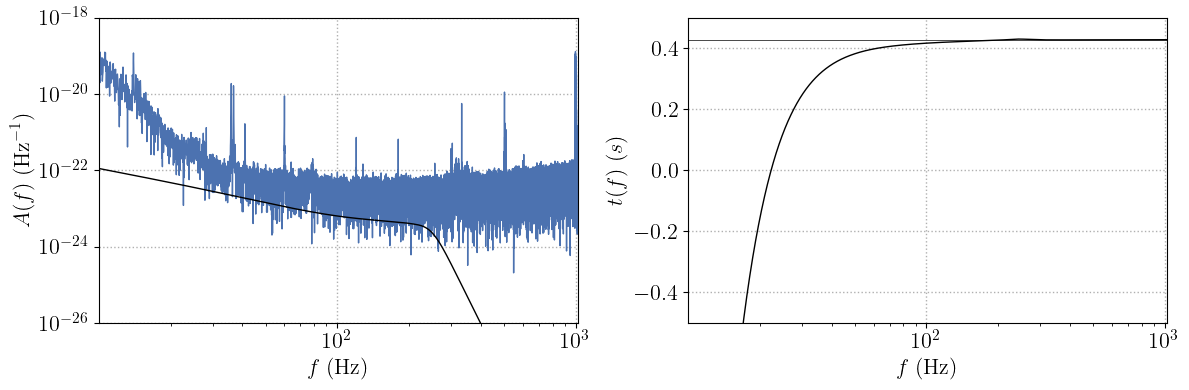

<Figure size 800x400 with 0 Axes>

In [104]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [freq, np.abs(data)], [freq, h0['amp']], rangex=None, rangey=[1e-26, 1e-18], colors=[plotutils.plotpalette[0], 'k'])
plotutils.lloglinearplot(axs[1], [freq, h0['tf']], rangex=None, rangey=[-0.5, 0.5], colors=['k'])
axs[1].axhline(Deltat0, c='k', lw=0.5)
for i in range(2):
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].set_ylabel(r'$A(f) \; (\mathrm{Hz}^{-1})$')
axs[1].set_ylabel(r'$t(f) \; (s)$')

fig.tight_layout()

# fig.savefig('./plots/psd_GW150914.pdf')

In [95]:
freq_fft = strain_H1_fd[:,0]
mask_ext = (5. < freq_fft) & (freq_fft < 1024.)
freq_ext = freq_fft[mask_ext]
h0_ext = signal_h(freq_ext, M0, q0, A0, Deltat0, alpha0)
h0_fd = np.zeros_like(freq_fft, dtype=complex)
w_ifft = pytools.window_planck_vec(freq_ext, 5., 1024., 5., 128.)
h0_fd[mask_ext] = w_ifft * h0_ext['amp'] * np.exp(1j*h0_ext['phase'])
h0_wbp_fd =  1./np.sqrt(psd_H1(freq_fft) / (2*df)) * h0_fd 

h0_td = pytools.ifft_real(np.array([freq_fft, np.real(h0_fd), np.imag(h0_fd)]).T)
h0_wbp_td = pytools.ifft_real(np.array([freq_fft, np.real(h0_wbp_fd), np.imag(h0_wbp_fd)]).T)

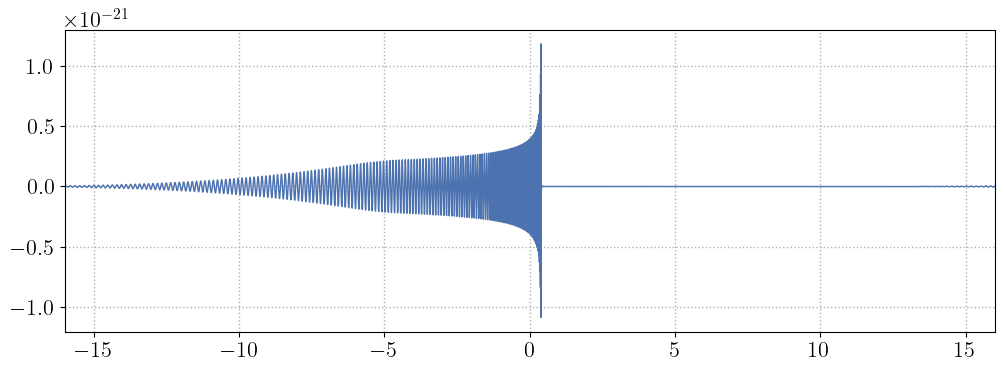

<Figure size 800x400 with 0 Axes>

In [87]:
fig, ax = plt.subplots(1,1, figsize=[12,4])
plotutils.lplot(ax, [h0_td[:,0], h0_td[:,1]])

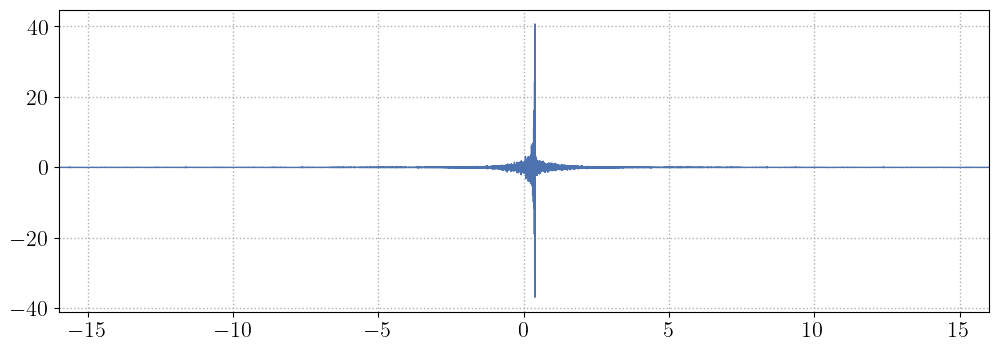

<Figure size 800x400 with 0 Axes>

In [89]:
fig, ax = plt.subplots(1,1, figsize=[12,4])
plotutils.lplot(ax, [h0_wbp_td[:,0], h0_wbp_td[:,1]])

Text(0.5, 0, '$t (\\mathrm{s})$')

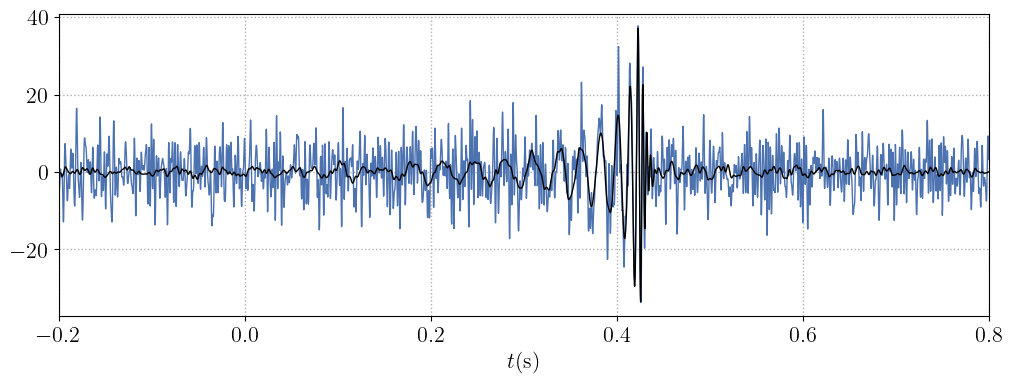

<Figure size 800x400 with 0 Axes>

In [302]:
rangex = [-0.2, 0.8]

fig, ax = plt.subplots(1,1, figsize=[12,4])
plotutils.lplot(ax, [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(ax, [h0_wbp_td[:,0], h0_wbp_td[:,1]], rangex=rangex, colors=['k'])

ax.set_xlabel(r'$t (\mathrm{s})$')

In [61]:
def h_wbp_td(M, q, A, Deltat, alpha):
    h_ext = signal_h(freq_ext, M, q, A, Deltat, alpha)
    h_fd = np.zeros_like(freq_fft, dtype=complex)
    w_ifft = pytools.window_planck_vec(freq_ext, 5., 1024., 5., 128.)
    h_fd[mask_ext] = w_ifft * h_ext['amp'] * np.exp(1j*h_ext['phase'])
    h_wbp_fd =  1./np.sqrt(psd_H1(freq_fft) / (2*df)) * h_fd 
    return pytools.ifft_real(np.array([freq_fft, np.real(h_wbp_fd), np.imag(h_wbp_fd)]).T)

In [115]:
len(chain_processed), len(h0_wbp_td)

(64000, 131072)

In [117]:
t_range = [-0.2, 0.8]
mask_t_range = (t_range[0] <= h0_wbp_td[:,0]) & (h0_wbp_td[:,0] <= t_range[-1])
t_r = h0_wbp_td[mask_t_range,0]
len(t_r)

4096

In [121]:
n_rand = 1000
inds = np.random.choice(range(len(chain_processed)), size=n_rand, replace=False)

h_wbp_td_all = np.zeros((len(t_r), n_rand), dtype=float)
for i in tqdm(range(n_rand)):
    M, q, A, Deltat, alpha = chain_processed[inds[i]]
    h_wbp_td_vals = h_wbp_td(M, q, A, Deltat, alpha)
    h_wbp_td_all[:,i] = h_wbp_td_vals[mask_t_range,1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [126]:
qs = np.array([0.025, 0.16, 0.5, 0.84, 0.975])

h_wbp_td_quantiles = np.quantile(h_wbp_td_all, qs, axis=1)
h_wbp_td_quantiles.shape

(5, 4096)

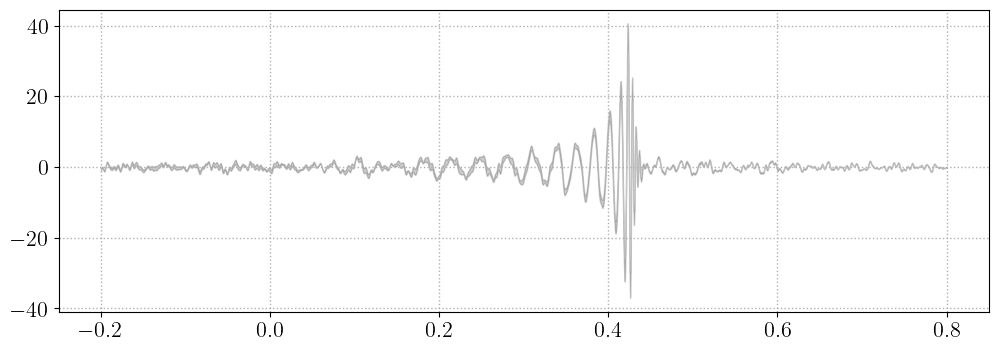

In [129]:
# NOTE: 2sigma waveform reconstruction is very narrow, is that genuine ?

rangex = [-0.2, 0.8]

fig, ax = plt.subplots(1,1, figsize=[12,4])
# plotutils.lplot(ax, [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
# plotutils.lplot(ax, [h0_wbp_td[:,0], h0_wbp_td[:,1]], rangex=rangex, colors=['k'])
ax.fill_between(t_r, h_wbp_td_quantiles[0], h_wbp_td_quantiles[4], color=['k'], alpha=0.2)

## Plotting FD waveform and PSD

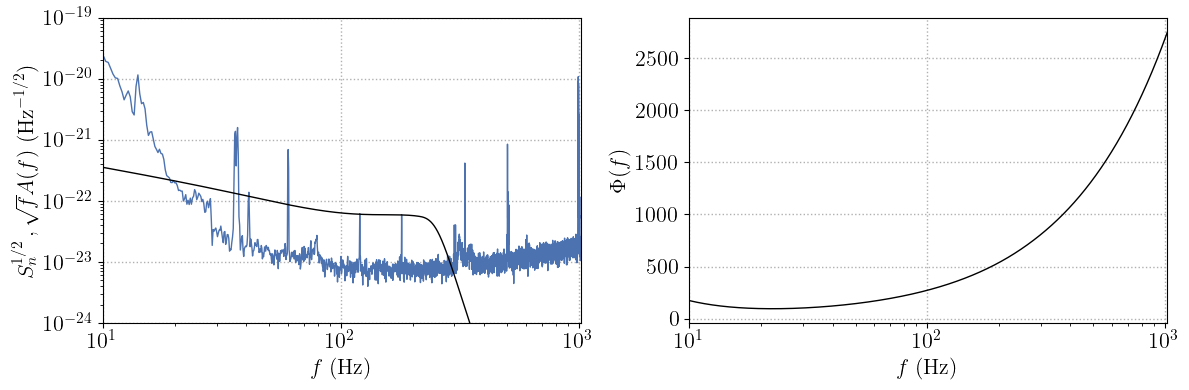

<Figure size 800x400 with 0 Axes>

In [139]:
rangey = [1e-24, 1e-19]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [freqs, np.sqrt(Pxx_H1)], rangex=[10., 1024.], rangey=rangey)
plotutils.lloglogplot(axs[0], [freq, np.sqrt(freq) * h0['amp']], rangex=[10., 1024.], rangey=rangey, colors=['k'])
plotutils.lloglinearplot(axs[1], [freq, h0['phase']], rangex=[10., 1024.], rangey=None, colors=['k'])
for i in range(2):
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].set_ylabel(r'$S_n^{1/2} \,, \sqrt{f}A(f) \; (\mathrm{Hz}^{-1/2})$')
axs[i].set_ylabel(r'$\Phi(f)$')

fig.tight_layout()

fig.savefig('./plots/signal_fd_GW150914.pdf')

# Video

In [ ]:
# Final command:

# ffmpeg -framerate 4 -i pe_signal_frame_%04d.png -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" video_pe_signal.mp4

# ffmpeg -framerate 4 -i pe_trace_frame_%04d.png -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" video_pe_trace.mp4

In [110]:
from matplotlib import gridspec

In [62]:
datadir = './samples/'
name = 'gw150914_example'

chain_unfold = np.load(datadir + 'chain_unfold_' + name + '.npy')
lnlikevals = np.load(datadir + 'lnlikevals_' + name + '.npy')
chain_processed = np.load(datadir + 'chain_processed_' + name + '.npy')
lnlike_processed = np.load(datadir + 'lnlike_processed_' + name + '.npy')

In [97]:
def h_wbp_td(M, q, A, Deltat, alpha):
    h_ext = signal_h(freq_ext, M, q, A, Deltat, alpha)
    h_fd = np.zeros_like(freq_fft, dtype=complex)
    w_ifft = pytools.window_planck_vec(freq_ext, 5., 1024., 5., 128.)
    h_fd[mask_ext] = w_ifft * h_ext['amp'] * np.exp(1j*h_ext['phase'])
    h_wbp_fd =  1./np.sqrt(psd_H1(freq_fft) / (2*df)) * h_fd 
    return pytools.ifft_real(np.array([freq_fft, np.real(h_wbp_fd), np.imag(h_wbp_fd)]).T)

In [ ]:
# Framerate 4, 400 iter, ds=4, 25s

In [288]:
def plt_pe_signal(istep, iframe, iwalkers_in, out=False):
    iwalkers = copy.deepcopy(iwalkers_in) # is it required ?
    h_wbp_td_list = []
    for iwalker in iwalkers:
        M, q, A, Deltat, alpha = chain_unfold[iwalker,istep,:]
        h_wbp_td_list += [h_wbp_td(M, q, A, Deltat, alpha)]
    
    rangex = [-0.8, 0.8]
    rangey = [-40., 40.]
    
    fig, ax = plt.subplots(1,1, figsize=[8,4])
    plotutils.lplot(ax, [time_d, strain_H1_td_wbp[:,1]], rangex=rangex, colors=['lightgrey'], rangey=rangey)
    plotutils.lplot(ax, *[[h_wbp_td_list[i][:,0], h_wbp_td_list[i][:,1]] for i in range(len(iwalkers))], rangex=rangex, rangey=rangey)

    ax.set_xlabel(r'$t \; (\mathrm{s})$')
    
    fig.tight_layout()
    
    if out:
        fig.savefig('./videos/pe_signal_frame_%04d.png' % iframe, dpi=200)

        plt.close(fig)

In [289]:
step_max = 600

def plt_pe_trace(istep, iframe, iwalkers_in, out=False):
    iwalkers = copy.deepcopy(iwalkers_in) # is it required ?
    
    rangex = [0, step_max]
    
    fig, axs = plt.subplots(4,1, figsize=[8,8])
    # lnL
    lnL_max = np.max(lnlike_processed)
    plotutils.llogplot(axs[0], *[[np.arange(step_max), -(lnlikevals[i] - lnL_max - 1)[:step_max]] for i in range(lnlikevals.shape[0])], rangey=None, colors=['lightgrey']*lnlikevals.shape[0])
    plotutils.llogplot(axs[0], *[[np.arange(istep+1), -(lnlikevals[i] - lnL_max - 1)[:istep+1]] for i in iwalkers], rangey=[0.5, 1e3], rangex=rangex)
    axs[0].set_ylabel(r'$-\ln \mathcal{L} + \mathrm{const.}$')
    # M
    plotutils.lplot(axs[1], *[[np.arange(step_max), chain_unfold[i,:step_max,0]] for i in range(lnlikevals.shape[0])], rangey=None, colors=['lightgrey']*lnlikevals.shape[0])
    plotutils.lplot(axs[1], *[[np.arange(istep+1), chain_unfold[i,:istep+1,0]] for i in iwalkers], rangey=[50., 90.], rangex=rangex)
    axs[1].set_ylabel(r'$M \; (M_\odot)$')
    # A
    plotutils.lplot(axs[2], *[[np.arange(step_max), chain_unfold[i,:step_max,2]] for i in range(lnlikevals.shape[0])], rangey=None, colors=['lightgrey']*lnlikevals.shape[0])
    plotutils.lplot(axs[2], *[[np.arange(istep+1), chain_unfold[i,:istep+1,2]] for i in iwalkers], rangey=[0., 1.], rangex=rangex)
    axs[2].set_ylabel(r'$A$')
    # Deltat
    plotutils.lplot(axs[3], *[[np.arange(step_max), chain_unfold[i,:step_max,3]] for i in range(lnlikevals.shape[0])], rangey=None, colors=['lightgrey']*lnlikevals.shape[0])
    plotutils.lplot(axs[3], *[[np.arange(istep+1), chain_unfold[i,:istep+1,3]] for i in iwalkers], rangey=[-1., 1.], rangex=rangex)
    axs[3].set_ylabel(r'$\Delta t \; (s)$')
    
    for i in range(4):
        axs[i].axvline(istep, c='k', ls='--', lw=1.)
    axs[3].set_xlabel(r'$\mathrm{Steps}$')
    
    fig.tight_layout()
    
    if out:
        fig.savefig('./videos/pe_trace_frame_%04d.png' % iframe, dpi=200)

        plt.close(fig)

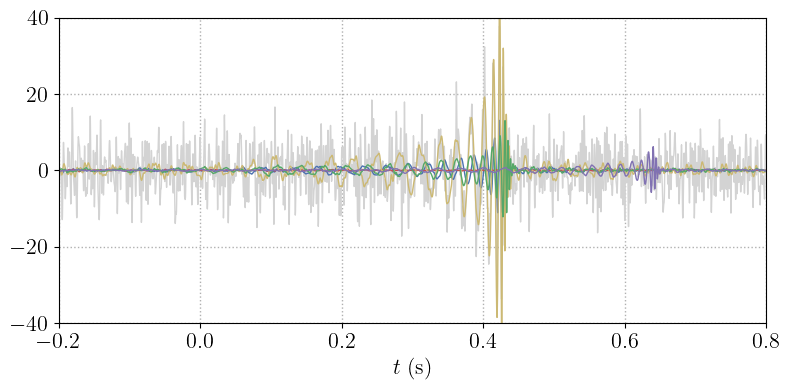

<Figure size 800x400 with 0 Axes>

In [275]:
plt_pe_signal(50, 0, [0,1,2,3,4])

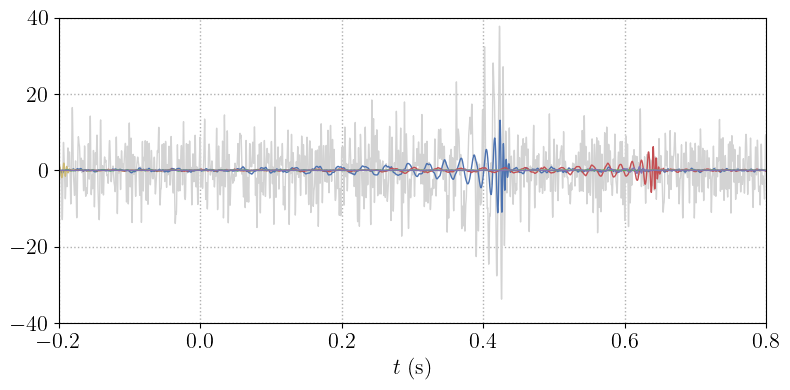

<Figure size 800x400 with 0 Axes>

In [276]:
plt_pe_signal(50, 0, iwalkers)

In [293]:
iwalkers = [0, 4, 8, 12, 16]

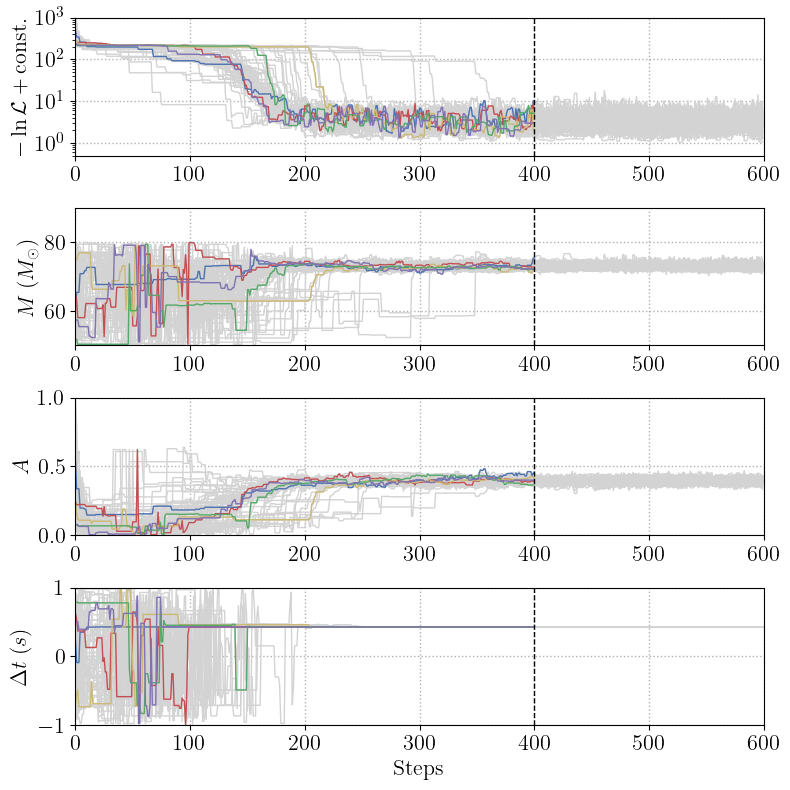

<Figure size 800x400 with 0 Axes>

In [277]:
plt_pe_trace(400, 0, iwalkers)

In [295]:
niter_vid = 400
ds = 1

inds = np.arange(2, niter_vid)
inds_ds = inds[::ds]

for iframe in tqdm(range(len(inds_ds))):
    istep = inds_ds[iframe]
    plt_pe_signal(istep, iframe, iwalkers, out=True)
    plt_pe_trace(istep, iframe, iwalkers, out=True)

  0%|          | 0/398 [00:00<?, ?it/s]

<Figure size 800x400 with 0 Axes>

# Hierarchical inference example

In [96]:
def rejection_sampling_uniform(pdf, max_pdf, uniform_range, N, **kwargs):
    pdf_uniform_val = uniform_range[1] - uniform_range[0]
    # Take a 10% margin wrt to the peak (might be an estimate)
    factor = 1.1 * max_pdf / pdf_uniform_val
    samples = []
    while len(samples) < N:
        x = np.random.uniform(uniform_range[0], uniform_range[1])
        u = np.random.uniform(0, 1)
        if u < pdf(x, **kwargs) / (factor * pdf_uniform_val):
            samples += [x]
    return samples

In [117]:
Rate = 100
alpha_true = 3
m_min = 2.
m_max = 100.
m_break = 10.
steepness = 2.

def population_model(m, alpha=3):
    # Normalization is approximative !
    norm = -1./(1 - alpha) * m_break**(-alpha + 1)
    return (1 + np.tanh((m - m_break) * steepness)) / 2 * m**(-alpha) / norm

def pdet_model(m):
    

def simulate_population(alpha):
    N = np.random.poisson(Rate)
    peak = 2 * population_model(m_break, alpha=alpha) # factor 2 margin, estimate
    m_samples = rejection_sampling_uniform(population_model, peak, [m_min, m_max], N, alpha=alpha)
    d_samples = 
    return m_samples

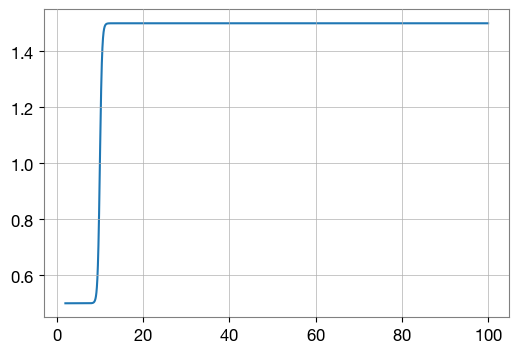

In [116]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
mvals = np.linspace(m_min, m_max, 10000)
ax.plot(mvals, (1 + np.tanh((mvals - m_break) * steepness) / 2))

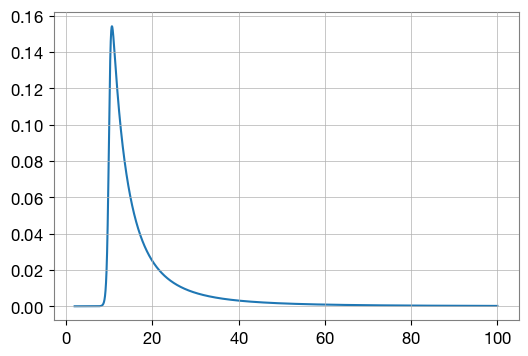

In [118]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
mvals = np.linspace(m_min, m_max, 10000)
ax.plot(mvals, population_model(mvals, alpha=3))

In [98]:
# Simulate 

In [119]:
m_samples = simulate_population(3)

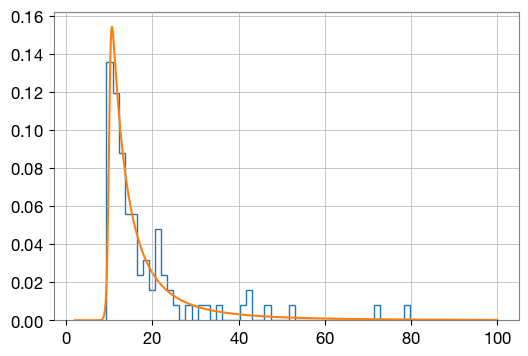

In [121]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(m_samples, histtype='step', density=True, bins=50)

mvals = np.linspace(m_min, m_max, 10000)
ax.plot(mvals, population_model(mvals, alpha=3))